Please do one of the following.


# Part I: Classification

1) Load in the dataset `https://d1pqsl2386xqi9.cloudfront.net/notebooks/Default.csv` into a pandas dataframe

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pydotplus
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from IPython.display import Image
from sklearn.externals.six import StringIO
%matplotlib inline

In [2]:
df = pd.read_csv('https://d1pqsl2386xqi9.cloudfront.net/notebooks/Default.csv', index_col=0)
df.head()

,default,student,balance,income
1,No,No,729.526495,44361.625074
2,No,Yes,817.180407,12106.134700
3,No,No,1073.549164,31767.138947
4,No,No,529.250605,35704.493935
5,No,No,785.655883,38463.495879


2) Convert `default` and `student` to categorical variables.

In [3]:
df['default'] = pd.get_dummies(df['default'])['Yes']
df['student'] = pd.get_dummies(df['student'])['Yes']
df.head()

,default,student,balance,income
1,0,0,729.526495,44361.625074
2,0,1,817.180407,12106.134700
3,0,0,1073.549164,31767.138947
4,0,0,529.250605,35704.493935
5,0,0,785.655883,38463.495879


For the converted variable `default` and `student`, 1 represents Yes and 0 represents No.

3) Make boxplots of all of the variables and a scatter plot of (balance,income) with the color
of the outcome of `default` labeled red if yes and blue if no. 

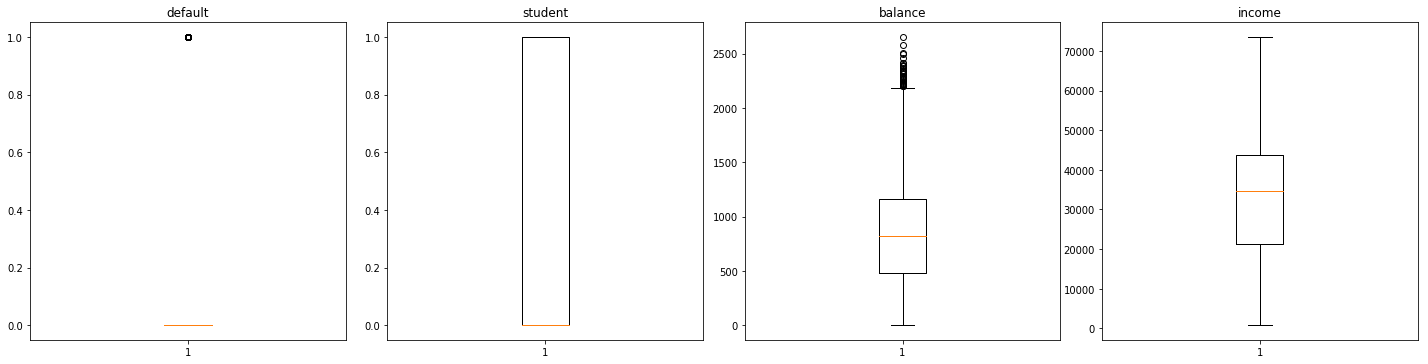

In [4]:
fig, axs = plt.subplots(1, 4, figsize=(20, 5))
fig.tight_layout()

for i in range(df.shape[1]):
    axs[i].boxplot(df.iloc[:, i])
    axs[i].set_title(df.columns[i])

plt.show()

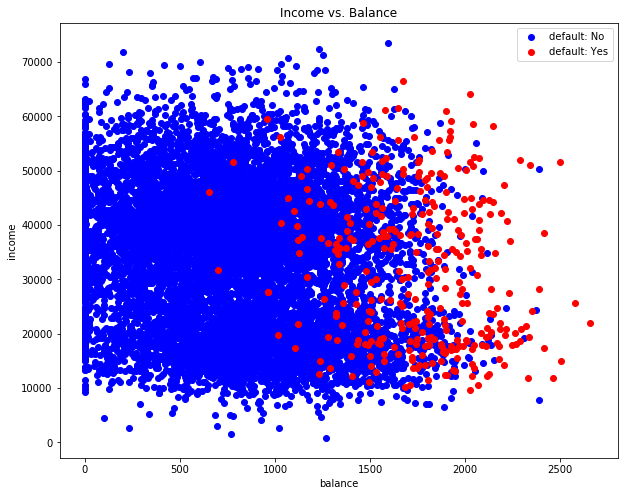

In [5]:
col = {0:'blue', 1:'red'}

plt.figure(figsize=(10, 8))
for name, group in df.groupby('default'):
    plt.scatter(group['balance'], group['income'], c = col[name])
plt.legend(['default: No', 'default: Yes'])
plt.xlabel('balance')
plt.ylabel('income')
plt.title('Income vs. Balance')
plt.show()

4) Train a model to predict if a student defaults on their loan or not using LogisticRegression based soley
on the `balance` and `income` variables. Plot the decision boundary in the scatter plot you made in 3) and compute the AUC ROC.

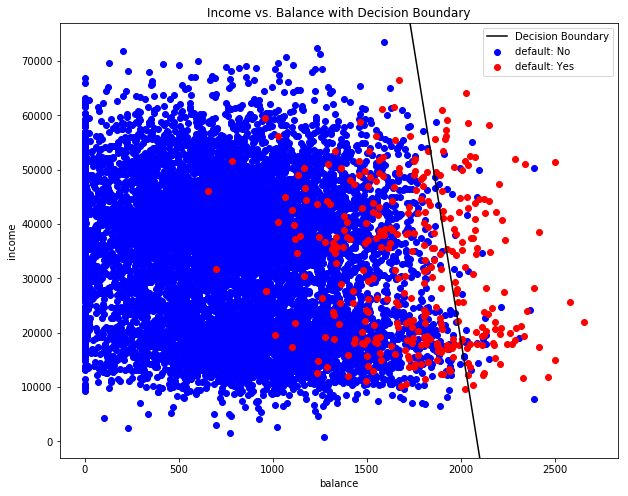

In [6]:
def generate_auc(X,y,clf_class,**kwargs):
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 4990)
    # Train the classifier
    classifier = clf_class(**kwargs)
    probas_ = classifier.fit(X_train, y_train).predict_proba(X_test)
    # Compute the AUC ROC
    fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
    roc_auc = auc(fpr, tpr)
    return fpr, tpr, roc_auc, thresholds, classifier

X = df.loc[df['student'] == 1][['balance', 'income']]
y = df.loc[df['student'] == 1]['default']
# Without regularization
fpr,tpr,roc_auc,thresholds,clf = generate_auc(X,y,LogisticRegression,penalty='l1',C=1e20)

# Plot the decision boundary
intercept = clf.intercept_
coef = clf.coef_[0]
x_coor = np.arange(0, 2700, 1)
y_coor = (intercept + coef[0] * x_coor) / -coef[1]

plt.figure(figsize=(10, 8))
for name, group in df.groupby('default'):
    plt.scatter(group['balance'], group['income'], c = col[name])
plt.plot(x_coor, y_coor, c = 'black')
plt.legend(['Decision Boundary', 'default: No', 'default: Yes'])
plt.xlabel('balance')
plt.ylabel('income')
plt.title('Income vs. Balance with Decision Boundary')
plt.ylim(-3000, 77000)
plt.show()

Area under the ROC curve: 0.936565


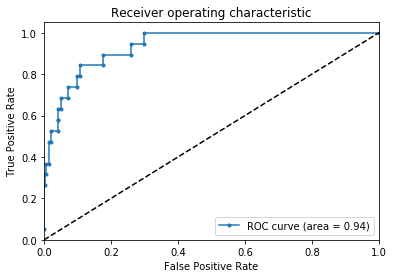

In [8]:
# Compute and plot the AUC ROC
def generate_ROCplot(fpr,tpr,label,roc_auc):
    plt.clf()
    plt.plot(fpr, tpr, '.-', label = 'ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0, 1])
    plt.ylim([0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc = 'lower right')
    plt.show()

print ("Area under the ROC curve: %f" % roc_auc)
generate_ROCplot(fpr,tpr,'LR',roc_auc)

5) Repeat 4) but with the student variable included. Optimize using Ridge regression and plot the ranking
of coefficients.  How does performance improve with the added variable?

Optimal regularization parameter: 0.006892612104349702


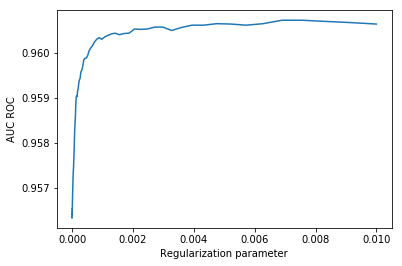

In [9]:
X = df[['student', 'balance', 'income']]
y = df['default']
# Standardization
scaler = StandardScaler()
X = X.as_matrix().astype(np.float)
X = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 4990)

alphas = np.logspace(-6, -2, 100)
roc_aucs = []
for alpha in alphas:
    fpr,tpr,roc_auc,thresholds,clf = generate_auc(X,y,LogisticRegression,C=alpha,penalty='l2')
    roc_aucs.append(roc_auc)

# Find the optimal Ridge regression
i_alpha_optim = np.argmax(roc_aucs)
alpha_optim = alphas[i_alpha_optim]
print("Optimal regularization parameter: %s" % alpha_optim)

plt.plot(alphas,roc_aucs)
plt.xlabel('Regularization parameter')
plt.ylabel('AUC ROC')
plt.show()

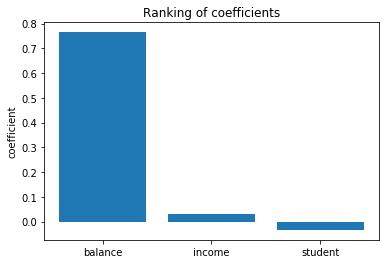

In [10]:
# Get the coefficients
model_optim = LogisticRegression(C=alpha_optim,penalty='l2')
coef = model_optim.fit(X,y).coef_[0]
dfCoeffs = pd.DataFrame({'type':['student', 'balance', 'income'], 'coef':coef})
dfCoeffs = dfCoeffs.sort_values(['coef'])[::-1]
plt.bar(dfCoeffs['type'], dfCoeffs['coef'])
plt.ylabel('coefficient')
plt.title('Ranking of coefficients')
plt.show()

Optimal area under the ROC curve: 0.960720


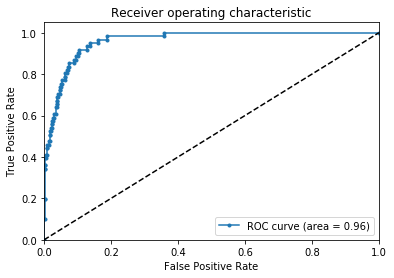

In [11]:
# Compute and plot the optimal AUC ROC
fpr,tpr,roc_auc,thresholds,clf = generate_auc(X,y,LogisticRegression,C=alpha_optim,penalty='l2')
print ("Optimal area under the ROC curve: %f" % roc_auc)
generate_ROCplot(fpr,tpr,'LR',roc_auc)

#### Answer:
Compared with part 4), it can be seen that the AUC ROC increases from 0.9366 to 0.9607. Thus, under the optimal regularization parameter for Ridge regression, the performance slightly improves with the inclusion of `student` variable.

6) Using cross validation, check that the model you built in 5) is robust (generalizes to other random folds of the dataset).

Area under the ROC curve on 5 folds: [0.95328682 0.95816419 0.93780451 0.962956   0.93523962]


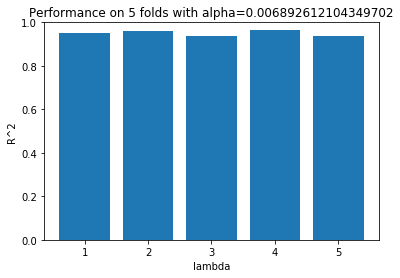

In [12]:
# Compute the AUC ROC with the optimal coefficient on 5 folds
model_optim = LogisticRegression(C=alpha_optim,penalty='l2')
roc_aucs = cross_val_score(model_optim, X, y, cv=5, scoring='roc_auc')

print("Area under the ROC curve on 5 folds: %s" % roc_aucs)
plt.xlabel('lambda')
plt.ylabel('R^2')
plt.ylim([0,1.])
plt.title('Performance on 5 folds with alpha=' + str(alpha_optim))
plt.bar(range(1,6),roc_aucs)
plt.show()

#### Answer:
According to above results, the AUC ROC scores on 5 random folds range from 0.9378 to 0.9630, which suggests that the model generalizes well to other random folds of the dataset. Thus, the model we built in part 5) is quite robust.

7) Train a Decision Tree classifier with maximum depth 5 and plot the decision tree. How does performance compare?

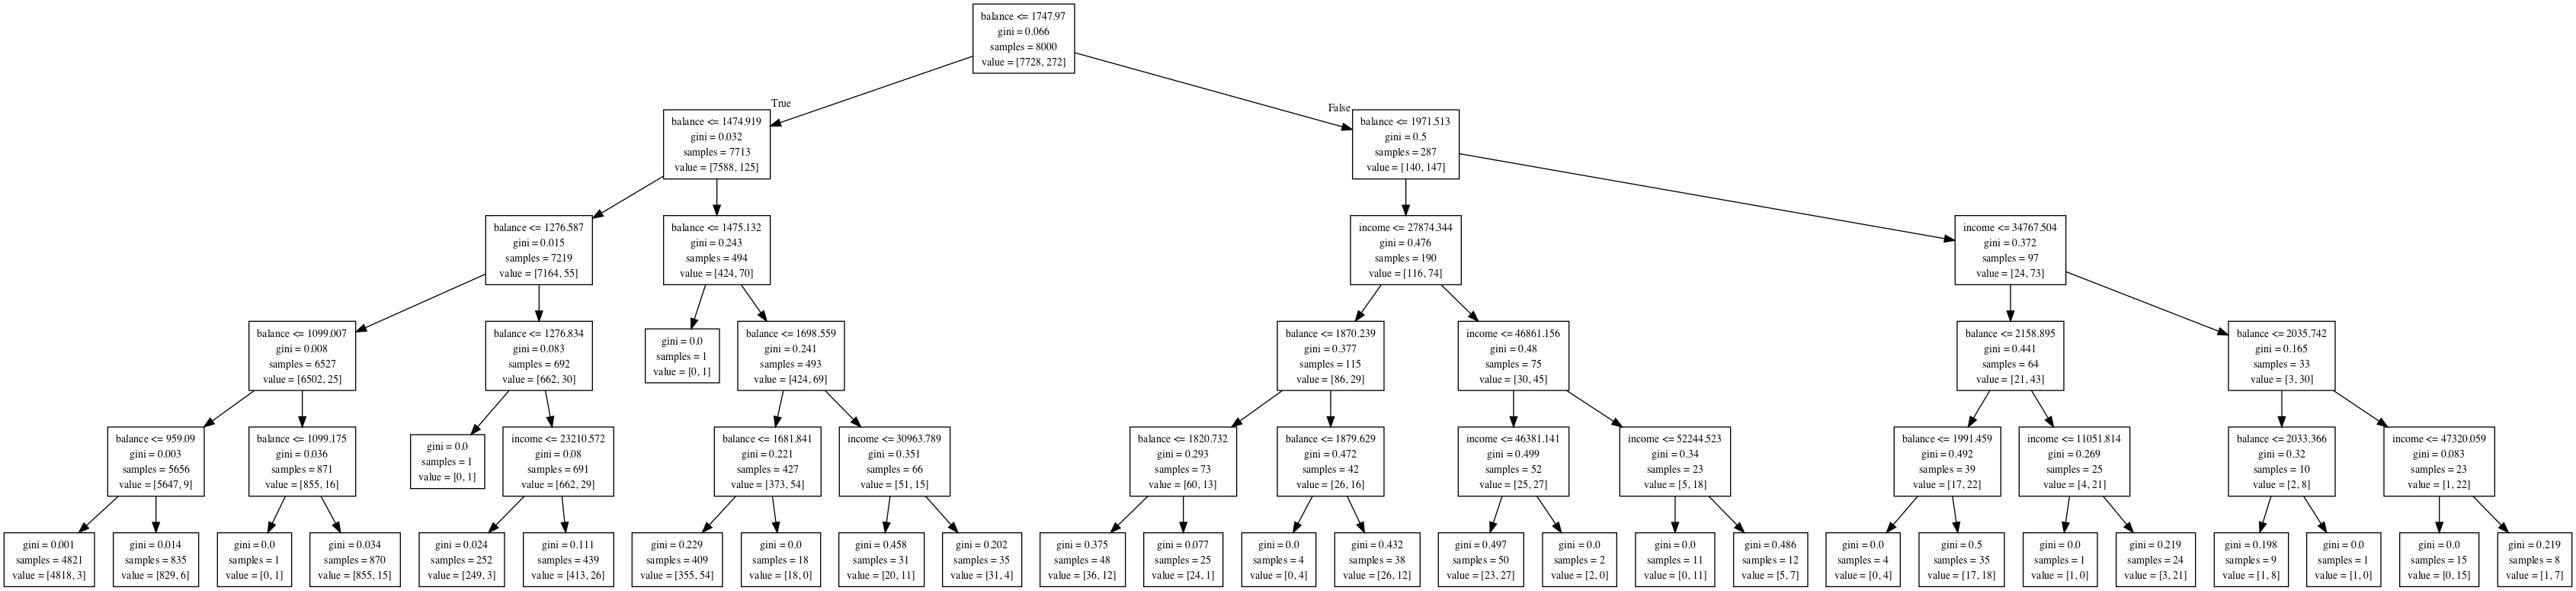

In [13]:
X = df[['student', 'balance', 'income']]
y = df['default']

# Train a Decision Tree classifier with maximum depth 5
fpr,tpr,roc_auc,thresholds,clf = generate_auc(X,y,DecisionTreeClassifier,max_depth=5)

# Plot the decision tree
dot_data=export_graphviz(clf, out_file=None, feature_names=X.columns)
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())

Area under the ROC curve: 0.942120


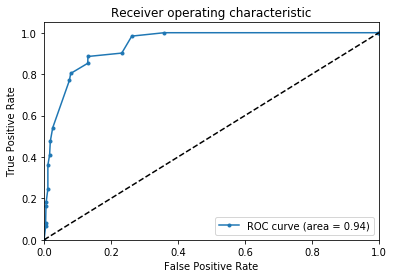

In [14]:
# Plot the AUC ROC
print ("Area under the ROC curve: %f" % roc_auc)
generate_ROCplot(fpr,tpr,'LR',roc_auc)

#### Answer:
The AUC ROC of the depth 5 Decision Tree classifier is 0.9421, which is slightly lower than 0.9607, the AUC ROC of the optimal Logistic regression with L2 penalty we found in part 5). This suggests that the depth 5 Decision Tree classifier performs slightly worse. Thus, we may consider penalizing the Decision Tree and determining the optimal decision tree depth.

8) Find the optimal decision tree depth and compute the AUC ROC. 

Optimal decision tree depth: 4


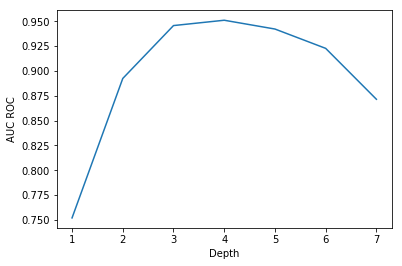

In [16]:
depths = range(1,8)
roc_aucs = []
for n in depths:
    fpr,tpr,roc_auc,thresholds,clf = generate_auc(X,y,DecisionTreeClassifier,max_depth=n)
    roc_aucs.append(roc_auc)

n_opt=depths[np.argmax(roc_aucs)]
print("Optimal decision tree depth: %s" % n_opt)

plt.plot(depths,roc_aucs)
plt.xlabel('Depth')
plt.ylabel('AUC ROC')
plt.show()

Optimal area under the ROC curve: 0.950968


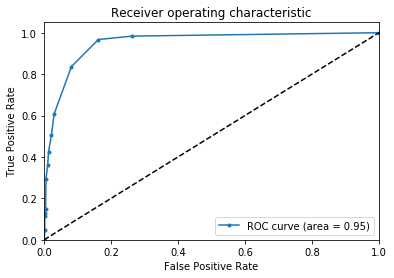

In [17]:
# Compute and plot the AUC ROC
fpr,tpr,roc_auc,thresholds,clf = generate_auc(X,y,DecisionTreeClassifier,max_depth=n_opt)
print ("Optimal area under the ROC curve: %f" % roc_auc)
generate_ROCplot(fpr,tpr,'LR',roc_auc)

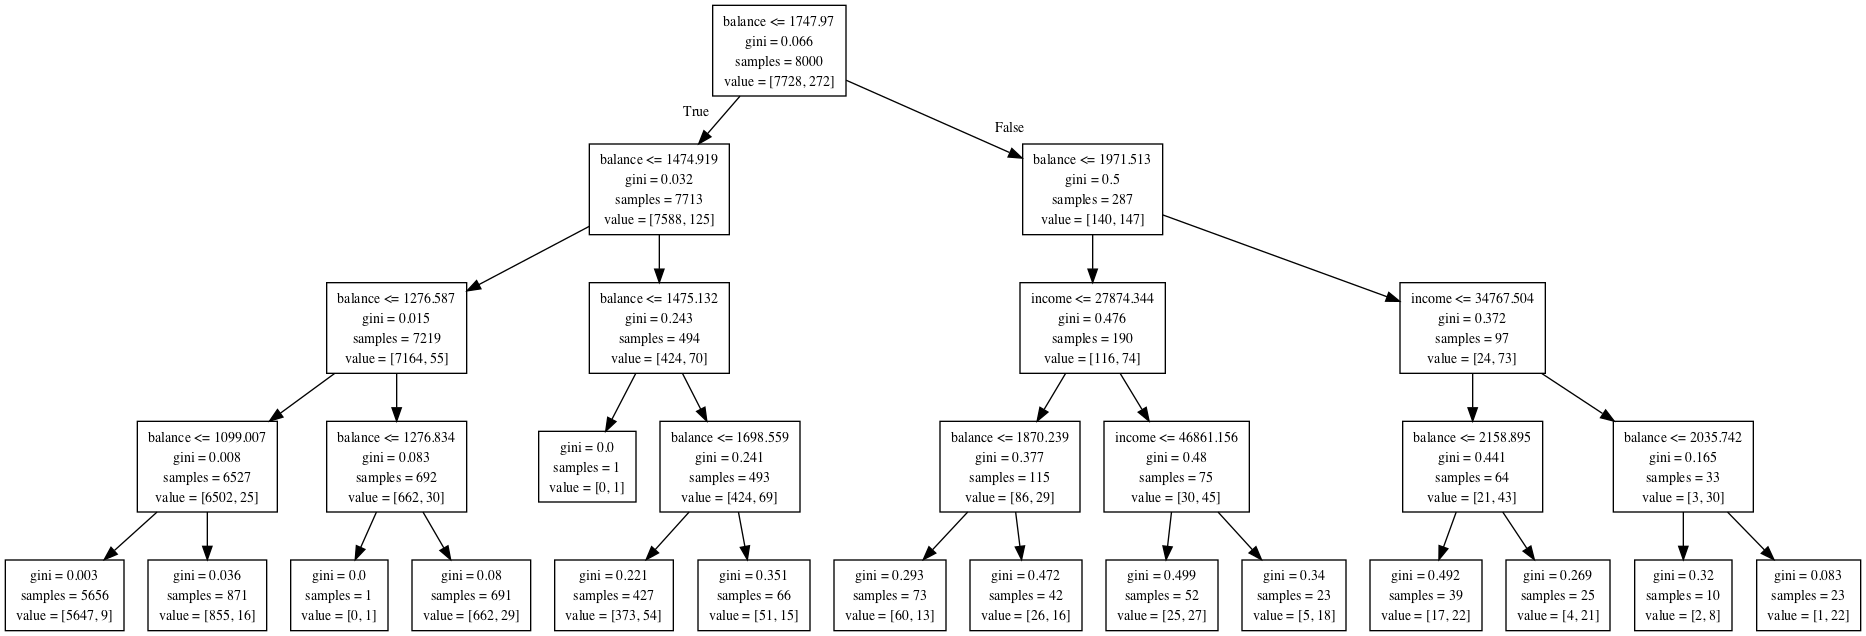

In [18]:
# Plot the optimal decision tree
dot_data=export_graphviz(clf, out_file=None, feature_names=X.columns)
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())

# Part II: Recommendation Systems. 

In this problem we will use the notebook https://github.com/Columbia-Intro-Data-Science/APMAE4990-/blob/master/notebooks/matrix_factorization_recommender.ipynb  as
a starting point.

1) Split the ratings matrix `R_df` into training and testing sets. Remember we need to do this for rows and columns now. 

2) Evaluate the performance of the matrix factorization model for $K=50$. In particular, measure the:
 - Precision.
 - Recall. 

You can round up or down to the nearest integer for the ratings. 

3) Construct an item/item and user/user model, and evaluate the performance as in 2). How does it compare?

4) Check how your answer to 3) changes (if at all) as you try different values of K for K=10, 20, 100. 